<a href="https://colab.research.google.com/github/Jvlia17/rodents-classification/blob/main/Rosegador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ten kod jest poświęcony kodowaniu w ramach pracy magisterskiej skupionej na opracowywaniu niestandardowego zestawu danych do rozpoznawania gryzoni przy użyciu sztucznej inteligencji. W jego ramach wykorzystuje się najnowocześniejsze technologie, różnorodne metody bilansowania danych, dostrojenie hiperparametrów oraz transfer learning w celu poprawy odporności i efektywności modelu.

Github: https://github.com/Jvlia17/rodents-classification

# **0. Pobranie bibliotek**

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns
import PIL.Image as Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')

In [2]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

# **1. Pobranie danych**

In [23]:
# Usuwanie istniejących folderów
!rm -rf sample_data

# Pobranie danych i wyodrębnienie ich
!wget https://www.dropbox.com/scl/fi/9kn0v6wrzu5u1i281k191/Rosegador.zip?rlkey=56u1mquuztup2db9diybpfy9c&dl=0

--2024-06-03 16:10:58--  https://www.dropbox.com/scl/fi/9kn0v6wrzu5u1i281k191/Rosegador.zip?rlkey=56u1mquuztup2db9diybpfy9c
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb097bbd556b04220154ab6b72f.dl.dropboxusercontent.com/cd/0/inline/CULhWPPMFqbx-4vC8rj2VZWrVY8Ria1NQ2iwGsvjg31Sk9SjhjdJsXLZ88OvWZKKn4OwHNeR3dLyJAWEHGYPKYQtw8xTPGBc_G0bQ5xmi3H615OHFLHi94RJqZLOiUeUGwzYF1D_nOxaezw7KjoYPvYx/file# [following]
--2024-06-03 16:10:59--  https://ucb097bbd556b04220154ab6b72f.dl.dropboxusercontent.com/cd/0/inline/CULhWPPMFqbx-4vC8rj2VZWrVY8Ria1NQ2iwGsvjg31Sk9SjhjdJsXLZ88OvWZKKn4OwHNeR3dLyJAWEHGYPKYQtw8xTPGBc_G0bQ5xmi3H615OHFLHi94RJqZLOiUeUGwzYF1D_nOxaezw7KjoYPvYx/file
Resolving ucb097bbd556b04220154ab6b72f.dl.dropboxusercontent.com (ucb097bbd556b04220154ab6b72f.dl.dropboxusercontent.com)... 162.125.81.15, 262

In [ ]:
!unzip /content/Rosegador.zip?rlkey=56u1mquuztup2db9diybpfy9c

# **2. Sprawdzenie danych**

In [3]:
# Sprawdzenie ilości obrazów w folderach

ROOT_DIR = "/content/Dataset"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Capybara', 3040), ('Hamster', 1361), ('Chinchilla', 338), ('Mouse', 248), ('Rat', 222), ('Guinea Pig', 1520)])

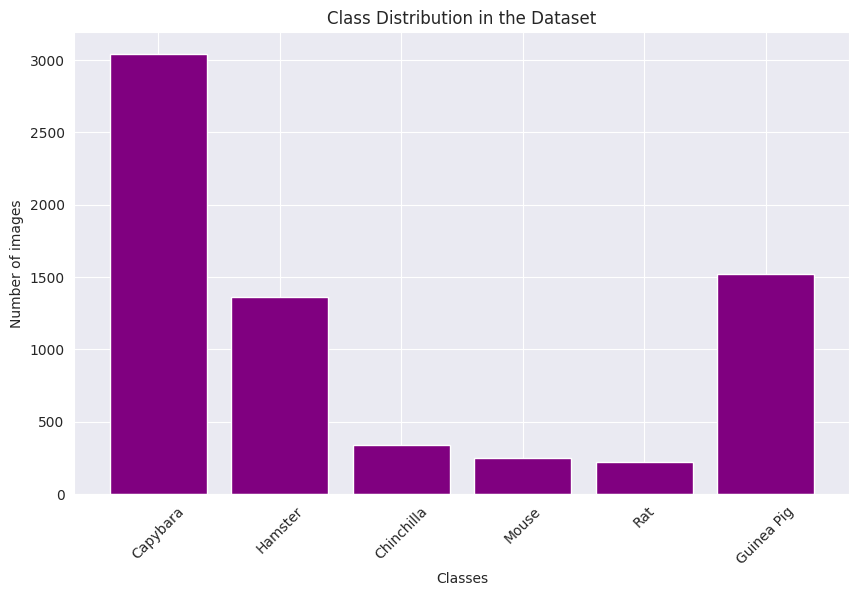

In [4]:
# Pokazanie na wykresie słupkowym rozkad liczebności klas

data_dir = '/content/Dataset'

# Zliczanie obrazów w każdej klasie
class_counts = {}
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Tworzenie wykresu słupkowego
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='purple')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45)
plt.show()

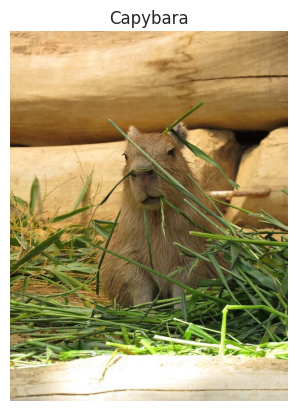

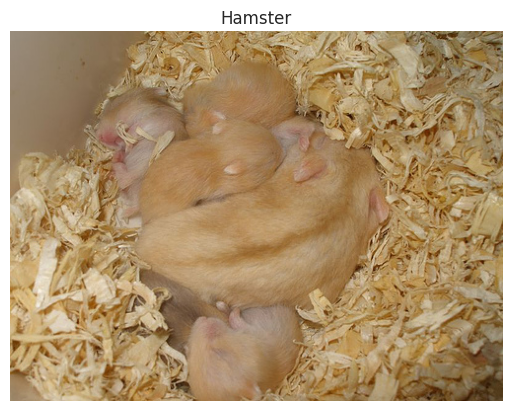

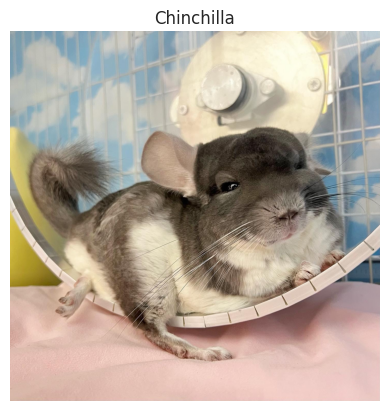

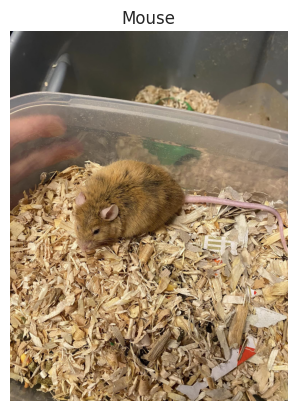

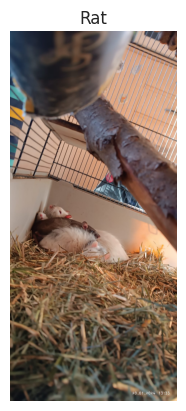

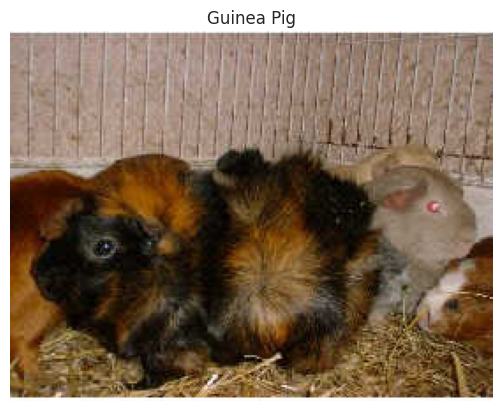

In [5]:
# Wyświetlenie randomowego obrazu z każdego folderu

data_dir = '/content/Dataset'

# Pobierz listę folderów w głównym katalogu
folders = os.listdir(data_dir)

# Iteruj po każdym folderze i wyświetl losowy obraz
for folder in folders:

    # Utwórz pełną ścieżkę do folderu
    folder_path = os.path.join(data_dir, folder)

    # Pobierz listę plików w folderze
    files = os.listdir(folder_path)

    # Wybierz losowy plik z folderu
    random_file = random.choice(files)

    # Utwórz pełną ścieżkę do losowego pliku
    file_path = os.path.join(folder_path, random_file)

    # Wczytaj obraz i wyświetl go
    image = Image.open(file_path)
    plt.imshow(image)
    plt.title(f"{folder}")
    plt.axis("off")
    plt.show()

# **3. Przygotowanie danych**

In [6]:
batch_size = 32
target_size = (224, 224)
dataset = "/content/Dataset"

In [7]:
# Tworzy obiekt Path, dzięki któremu będziemy łatwiej operowali na ścieżkach plików
image_dir = Path(dataset)

# Używa metody glob do wyszukiwania plików o danych rozszerzeniach, wyniki są łączone w jedną listę
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.JPEG'))

# Dzięki temu dla każdego pliku mamy etykietę, będącą nazwą katalogu
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Konwertuje listę na serię Pandas, wszystkie ścieżki są typu String
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Łączy filepaths i labels w jedną ramkę danych Pandas: śieżka pliku i etykieta
image_df = pd.concat([filepaths, labels], axis=1)

In [8]:
# Dzielimy dane: train_df ma 70% oryginalnych danych, test_df ma 30%
train_df, test_df = train_test_split(image_df, test_size=0.3, shuffle=True, random_state=42)

# **4. Balansowanie zbioru**

## 4.1 Undersampling

In [ ]:
class_counts = train_df['Label'].value_counts()

# Redukujemy do liczby próbek klasy najmniej licznej
min_class_count = class_counts.min()

# Przeprowadzenie undersamplingu
sampled_dfs = []
for label in train_df['Label'].unique():

    # Wybieramy próbki z danej klasy
    class_df = train_df[train_df['Label'] == label]

    # Losowo redukujemy liczbę próbek do wartości min_class_count
    sampled_dfs.append(class_df.sample(n=min_class_count, random_state=42))

# Łączenie zredukowanych DataFrame'ów z każdej klasy
train_df = pd.concat(sampled_dfs).reset_index(drop=True)

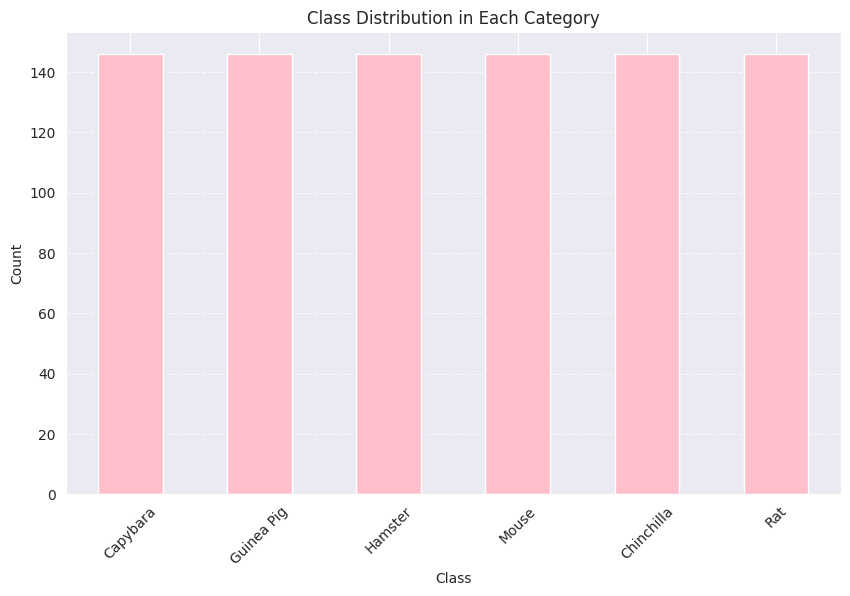

In [ ]:
# Obliczamy liczbę próbek dla każdej klasy w train_df
class_counts = train_df['Label'].value_counts()

# Tworzymy wykres
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='pink')
plt.title('Class Distribution in Each Category')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 4.2 Oversampling

In [ ]:
class_counts = train_df['Label'].value_counts()

# Zwiększamy liczbę próbek do klasy najbardziej licznej
max_class_count = class_counts.max()

# Przeprowadzenie oversamplingu
oversampled_dfs = []
for label in train_df['Label'].unique():

    # Wybieramy próbki z danej klasy
    class_df = train_df[train_df['Label'] == label]

    # Powielamy próbki do osiągnięcia max_class_count, jeśli jest ich za mało
    if len(class_df) < max_class_count:

        # Powielamy próbki i ewentualnie dodajemy lekką augmentację
        class_df_oversampled = class_df.sample(n=max_class_count, replace=True, random_state=42)
        oversampled_dfs.append(class_df_oversampled)
    else:
        oversampled_dfs.append(class_df)

# Łączenie powielonych DataFrame'ów z każdej klasy
train_df = pd.concat(oversampled_dfs).reset_index(drop=True)

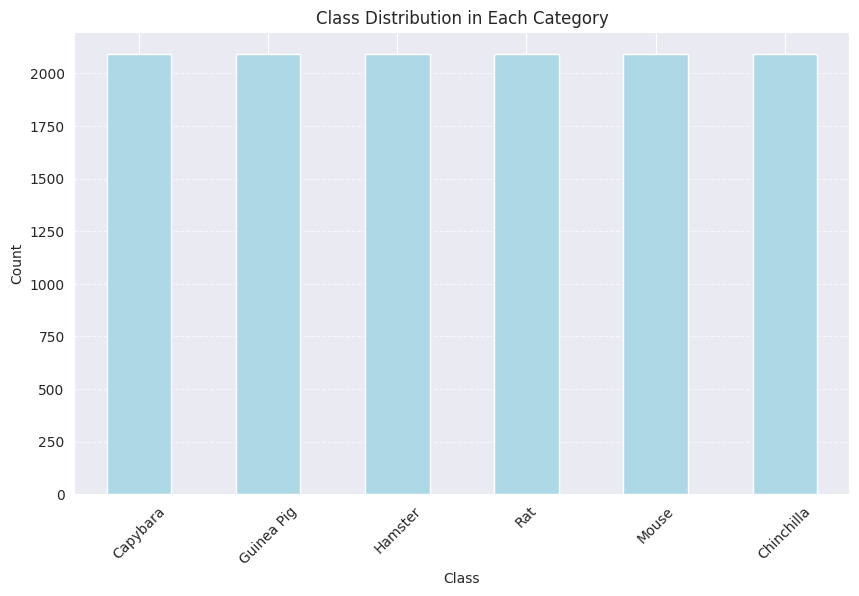

In [ ]:
# Obliczamy liczbę próbek dla każdej klasy w train_df
class_counts = train_df['Label'].value_counts()

# Tworzymy wykres
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='lightblue')
plt.title('Class Distribution in Each Category')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 4.3 Class weighting

Błędy popełniane na próbkach z mniej licznych klas mają większy wpływ

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Konwersja etykiet na wartości numeryczne, jeśli są one kategorialne
labels = pd.factorize(train_df['Label'])[0]

# Uzyskanie unikalnych klas i odpowiadających im wag
classes = np.unique(labels)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)

class_weights = dict(zip(classes, weights))

# **5. Przygotowanie danych do modelu**

In [10]:
# Uniwersalny

"""
# Generator danych dla treningu
train_generator = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20
)

# Generator danych dla testowania
test_generator = ImageDataGenerator(rescale=1 / 255.0)
"""

# EfficientNet - B4

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.3
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)



# ResNet - 152
"""
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.3
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)
"""

# DenseNet - 121
"""
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    validation_split=0.3
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)
"""

# MobileNetv2
"""
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.3
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
)
"""

"""
# VGG16

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,  # Zmiana na funkcję preprocessingu VGG16
    validation_split=0.3  # Zachowaj podział na zestaw walidacyjny
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input  # Zmiana na funkcję preprocessingu VGG16
)
"""

'\n# VGG16\n\ntrain_generator = ImageDataGenerator(\n    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,  # Zmiana na funkcję preprocessingu VGG16\n    validation_split=0.3  # Zachowaj podział na zestaw walidacyjny\n)\n\ntest_generator = ImageDataGenerator(\n    preprocessing_function=tf.keras.applications.vgg16.preprocess_input  # Zmiana na funkcję preprocessingu VGG16\n)\n'

In [11]:
# # Generatory do iteracyjnego ładowania i przetwarzania obrazów w batchach podczas treningu, walidacji i testowania modelu

from sklearn.model_selection import StratifiedKFold

# Przygotuj etykiety klas
y = train_df['Label']

# Tworzenie obiektu StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iteracja przez foldy
for train_index, val_index in skf.split(train_df, y):
    train_data = train_df.iloc[train_index]
    val_data = train_df.iloc[val_index]

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_data,
        x_col='Filepath',
        y_col='Label',
        target_size=target_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        subset='training'
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=val_data,
        x_col='Filepath',
        y_col='Label',
        target_size=target_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        subset='validation'
    )

    test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 2635 validated image filenames belonging to 6 classes.
Found 282 validated image filenames belonging to 6 classes.
Found 2018 validated image filenames belonging to 6 classes.
Found 2636 validated image filenames belonging to 6 classes.
Found 282 validated image filenames belonging to 6 classes.
Found 2018 validated image filenames belonging to 6 classes.
Found 2636 validated image filenames belonging to 6 classes.
Found 282 validated image filenames belonging to 6 classes.
Found 2018 validated image filenames belonging to 6 classes.
Found 2636 validated image filenames belonging to 6 classes.
Found 282 validated image filenames belonging to 6 classes.
Found 2018 validated image filenames belonging to 6 classes.
Found 2636 validated image filenames belonging to 6 classes.
Found 282 validated image filenames belonging to 6 classes.
Found 2018 validated image filenames belonging to 6 classes.


# **6 Augmentacja danych**

In [12]:
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# **7. Wybranie modelu**

## 7.0 Własny model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32,(3,3), input_shape=(224, 224, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional layer 2
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units= 1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=6, activation='relu'))

## 7.1 EfficientNet - B4

In [13]:
from tensorflow.keras.applications import EfficientNetB4

# Load the pretrained EfficientNetB4 model
pretrained_model = EfficientNetB4(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False

## 7.2 ResNet-152

In [ ]:
from tensorflow.keras.applications import ResNet152

# Load the pretrained ResNet152 model
pretrained_model = ResNet152(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False

234698864/234698864 [==============================] - 12s 0us/step


## 7.3 DenseNet - 121

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Load the pretrained DenseNet121 model
pretrained_model = DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False

## 7.4 MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Set the model to be non-trainable
pretrained_model.trainable = False

9406464/9406464 [==============================] - 2s 0us/step


## 7.5 VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

# Load the pretrained model
pretrained_model = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Set the model to be non-trainable
pretrained_model.trainable = False


# **8. Trenowanie modelu**

In [14]:
# Create checkpoint callback
checkpoint_path = "./bestmodel.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [15]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs

early_stopping = EarlyStopping(monitor='val_loss',  # Monitorowanie zmiany val_loss
                               patience=5,  # Liczba epok bez poprawy po której trening zostanie przerwany
                               verbose=1,  # Ustawienie na 1 lub 2 włącza komunikaty
                               restore_best_weights=True)  # Przywrócenie najlepszych wag po zakończeniu

In [16]:
from keras.callbacks import ReduceLROnPlateau

# Ustawienie callbacku

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

In [17]:
inputs = pretrained_model.input  # Pobiera warstwę wejściową wstępnie wytrenowanego modelu
x = augment(inputs) # Augmentacja danych

# Nasz model
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.40)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.40)(x)

outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr,
    ]
)

"""
# Dla wersji z wagami
history = model.fit(
    train_images,
    class_weight=class_weights,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr,
    ]
)
"""

Epoch 1/100
83/83 [==============================] - 64s 436ms/step - loss: 1.5113 - accuracy: 0.5645 - val_loss: 0.6114 - val_accuracy: 0.8227 - lr: 1.0000e-04
Epoch 2/100
83/83 [==============================] - 28s 332ms/step - loss: 0.7069 - accuracy: 0.7853 - val_loss: 0.4862 - val_accuracy: 0.8511 - lr: 1.0000e-04
Epoch 3/100
83/83 [==============================] - 28s 334ms/step - loss: 0.5425 - accuracy: 0.8289 - val_loss: 0.4369 - val_accuracy: 0.8475 - lr: 1.0000e-04
Epoch 4/100
83/83 [==============================] - 28s 333ms/step - loss: 0.4681 - accuracy: 0.8498 - val_loss: 0.4149 - val_accuracy: 0.8652 - lr: 1.0000e-04
Epoch 5/100
83/83 [==============================] - 27s 322ms/step - loss: 0.4296 - accuracy: 0.8615 - val_loss: 0.3926 - val_accuracy: 0.8617 - lr: 1.0000e-04
Epoch 6/100
83/83 [==============================] - 28s 337ms/step - loss: 0.4068 - accuracy: 0.8794 - val_loss: 0.3885 - val_accuracy: 0.8546 - lr: 1.0000e-04
Epoch 7/100
83/83 [===============

'\n# Dla wersji z wagami\nhistory = model.fit(\n    train_images,\n    class_weight=class_weights,\n    steps_per_epoch=len(train_images),\n    validation_data=val_images,\n    validation_steps=len(val_images),\n    epochs=100,\n    callbacks=[\n        early_stopping,\n        checkpoint_callback,\n        reduce_lr,\n    ]\n)\n'

In [18]:
# Zapisanie wag modelu -> nie jest konieczne, bo i tak więcej działam na zapisanym modelu
model.save_weights('models_weights.h5')

# **9. Ewaluacja modelu**

In [19]:
from keras.models import load_model

# Wczytanie modelu wraz z wagami jeśli go nie ma
# model = load_model("/content/animals_eff.h5")

results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.22287
Test Accuracy: 92.77%


## 9.1 Training vs validation accuracy/loss

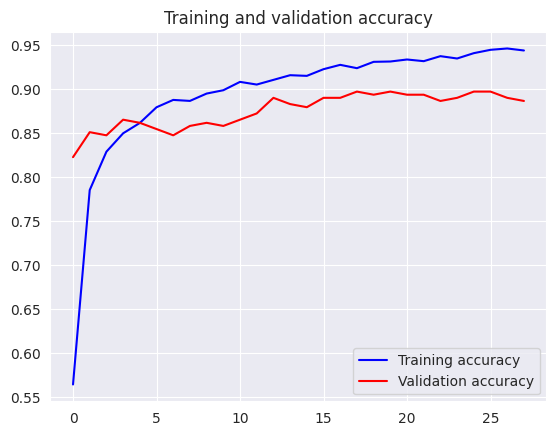

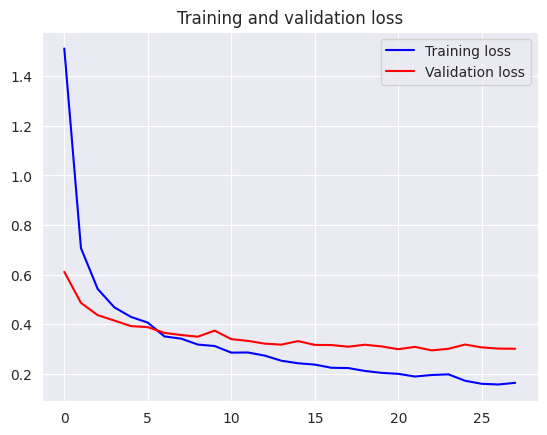

In [20]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## 9.2 Predykcje na test data

In [21]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

64/64 [==============================] - 22s 289ms/step
The first 5 predictions: ['Capybara', 'Capybara', 'Hamster', 'Capybara', 'Capybara']


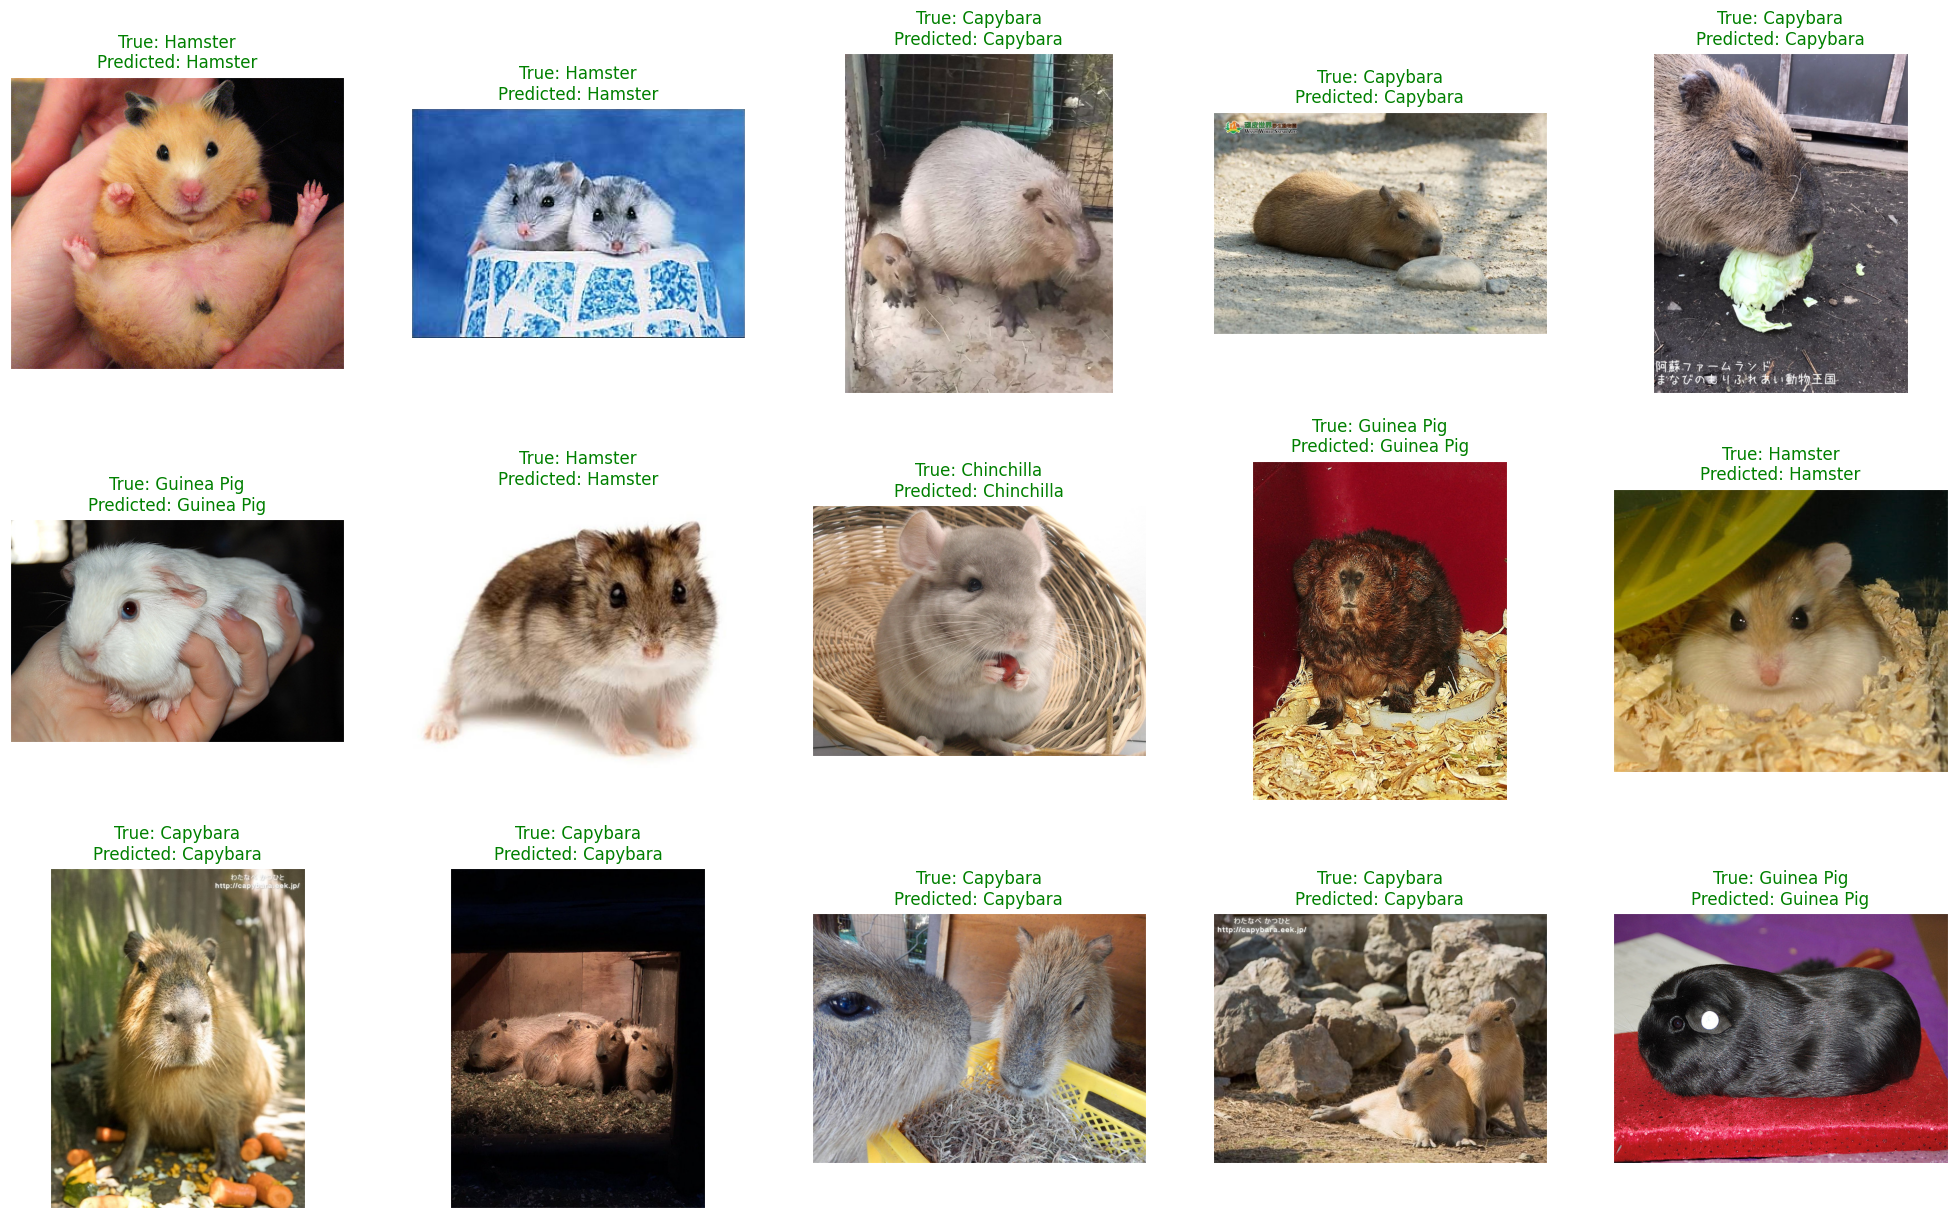

<Figure size 640x480 with 0 Axes>

In [22]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## 9.3. Macierz pomyłek

In [23]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    Capybara       0.99      0.99      0.99       948
  Chinchilla       0.90      0.86      0.88       100
  Guinea Pig       0.93      0.97      0.95       440
     Hamster       0.88      0.94      0.91       392
       Mouse       0.52      0.50      0.51        74
         Rat       0.67      0.28      0.40        64

    accuracy                           0.93      2018
   macro avg       0.81      0.76      0.77      2018
weighted avg       0.92      0.93      0.92      2018



In [24]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Capybara       0.986301  0.987342  0.986821   948.000000
Chinchilla     0.895833  0.860000  0.877551   100.000000
Guinea Pig     0.932018  0.965909  0.948661   440.000000
Hamster        0.883055  0.943878  0.912454   392.000000
Mouse          0.521127  0.500000  0.510345    74.000000
Rat            0.666667  0.281250  0.395604    64.000000
accuracy       0.927651  0.927651  0.927651     0.927651
macro avg      0.814167  0.756396  0.771906  2018.000000
weighted avg   0.922732  0.927651  0.922417  2018.000000

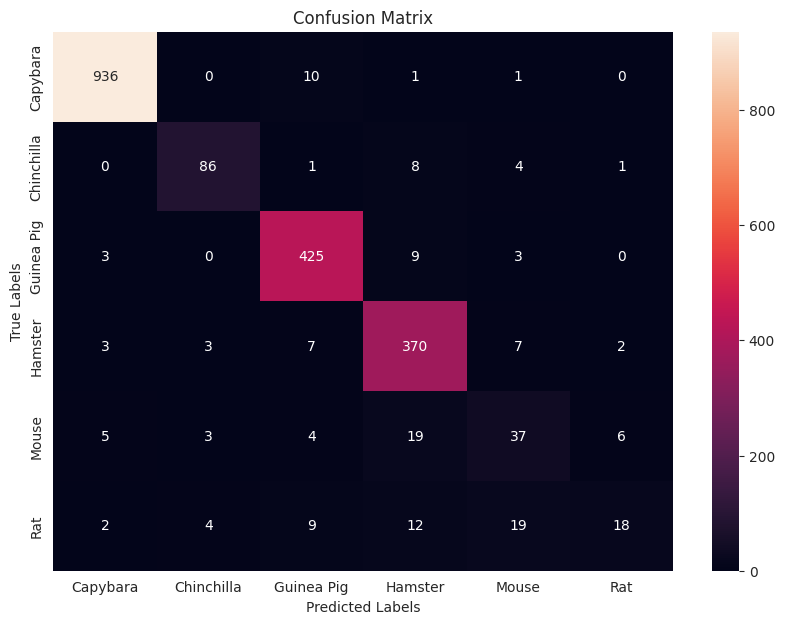

In [25]:
# Załóżmy, że `y_test` to prawdziwe etykiety, a `pred` to przewidywane etykiety
cm = confusion_matrix(y_test, pred)

# Etykiety dla osi w macierzy pomyłek
labels = list(labels.values())  # Założenie, że `labels` jest słownikiem

# Tworzenie heatmapy z macierzy pomyłek
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()